### Installing required libraries and modules

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
#import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from glob import glob
import seaborn as sns
from PIL import Image
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
#import matplotlib as plt
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [ ]:
skinDf = pd.read_csv('HAM10000_metadata.csv')
skinDf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
skinDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


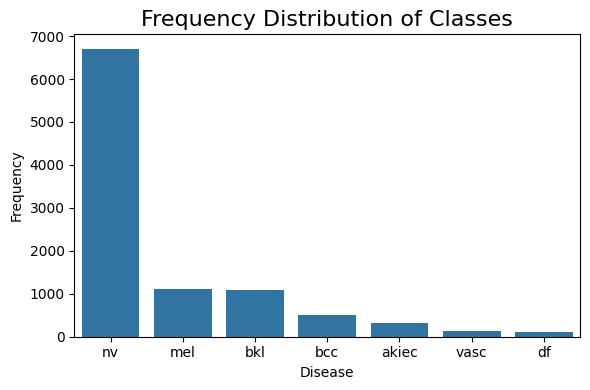

In [ ]:
# Distribution of data points per classes
plt.figure(figsize=(6, 4))
sns.countplot(x='dx', data=skinDf, order=skinDf['dx'].value_counts().index)  # Set order based on frequency
plt.xlabel('Disease', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Distribution of Classes', size=16)
plt.tight_layout()
plt.show()

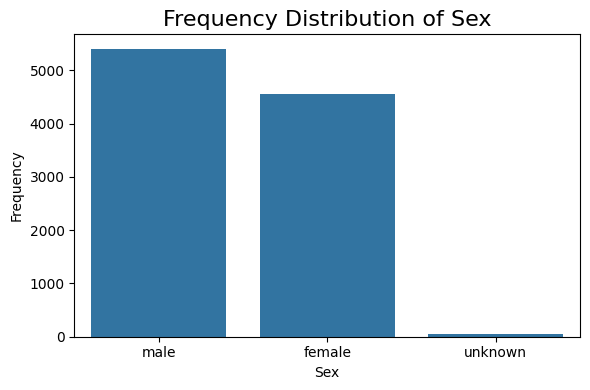

In [ ]:
# Distribution of data points per classes

plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=skinDf, order=skinDf['sex'].value_counts().index)  # Set order based on frequency
plt.xlabel('Sex', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Distribution of Sex', size=16)
plt.tight_layout()
plt.show()

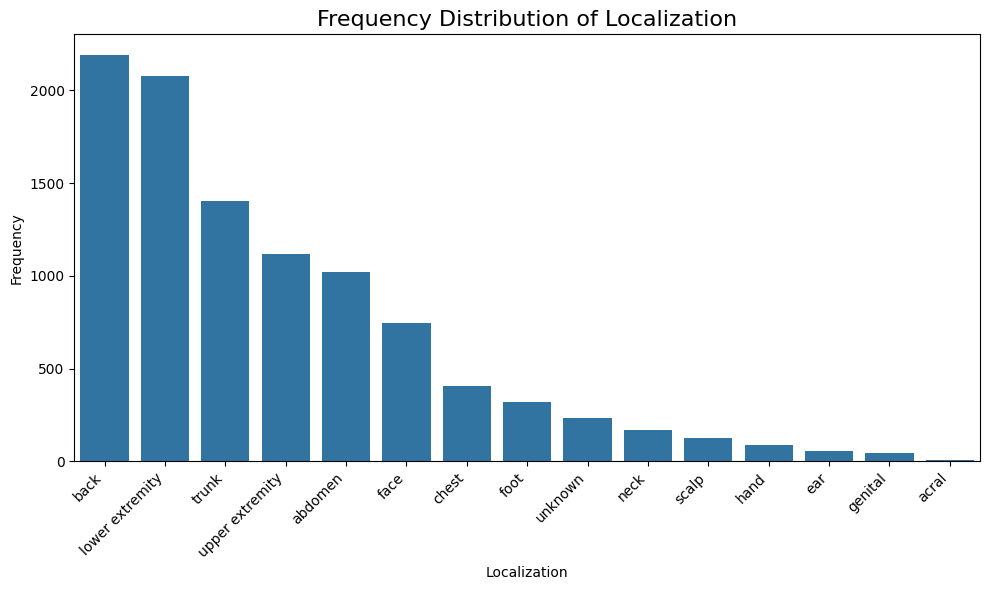

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='localization', data=skinDf, order=skinDf['localization'].value_counts().index)  # Set order based on frequency
plt.xlabel('Localization', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Frequency Distribution of Localization', size=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()

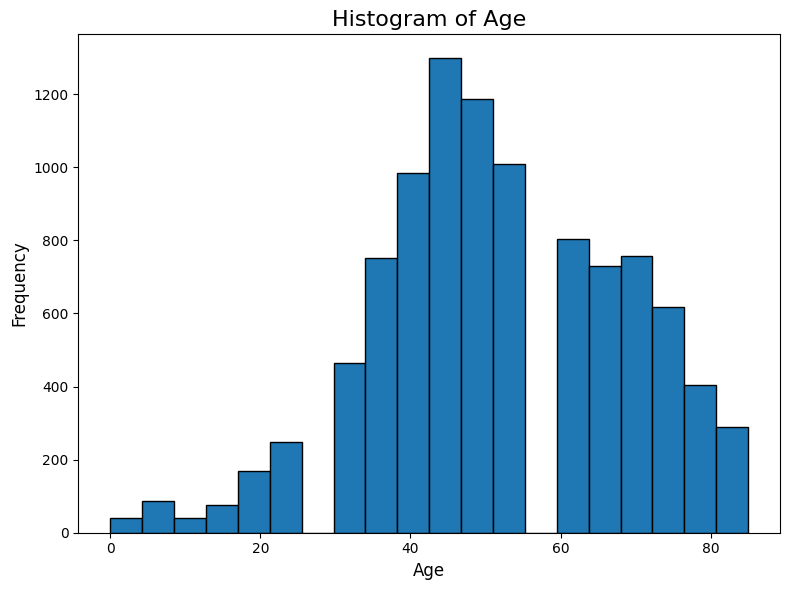

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(skinDf['age'], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Age', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Histogram of Age', size=16)
plt.tight_layout()
plt.show()

##Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(skinDf['dx'])
skinDf['label']=labelEncoder.transform(skinDf['dx'])

In [ ]:
diagnoses = labelEncoder.classes_
encoded_labels = labelEncoder.transform(diagnoses)
diagnosis_mapping = dict(zip(encoded_labels, diagnoses))
for label, diagnosis in diagnosis_mapping.items():
    print(f"Label {label} represents diagnosis: {diagnosis}")

Label 0 represents diagnosis: akiec
Label 1 represents diagnosis: bcc
Label 2 represents diagnosis: bkl
Label 3 represents diagnosis: df
Label 4 represents diagnosis: mel
Label 5 represents diagnosis: nv
Label 6 represents diagnosis: vasc


In [ ]:
diagnosis_counts = skinDf['dx'].value_counts()
diagnosis_counts

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [ ]:
# Path to the folders containing the images
import os

folder1_path = r'HAM10000_images_part_1'
folder2_path = r'HAM10000_images_part_2'

# Creating mapping between images and dataset
image_mapping = {}

# Iteratinf over images in folder 1
for filename in os.listdir(folder1_path):
    # Extract the unique identifier from the filename
    image_id = filename.split('.')[0]  # Assuming filenames are in the format 'ISIC_0027419.jpg'
    # Adding the mapping to the dictionary
    image_mapping[image_id] = os.path.join(folder1_path, filename)

# Iterate over images in folder 2
for filename in os.listdir(folder2_path):
    image_id = filename.split('.')[0]
    image_mapping[image_id] = os.path.join(folder2_path, filename)

# Linking images with the dataset
skinDf['image_path'] = skinDf['image_id'].map(image_mapping)

skinDf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
import cv2
import numpy as np

# Function for reading and resizing the images
def read_and_resize_image(image_path, target_size=(32, 32)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)
    # Convert BGR to RGB format
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return rgb_image

# Appliying row wise
skinDf['image_array'] = skinDf['image_path'].apply(lambda x: read_and_resize_image(x))

skinDf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,image_path,image_array
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 148, 187], [194, 153, 191], [197, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[23, 14, 25], [56, 40, 66], [106, 80, 114], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[186, 133, 146], [198, 145, 157], [195, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[31, 16, 27], [86, 55, 70], [126, 81, 97], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,HAM10000_images_part_2/ISIC_0031633.jpg,"[[[153, 110, 134], [188, 142, 171], [209, 158,..."


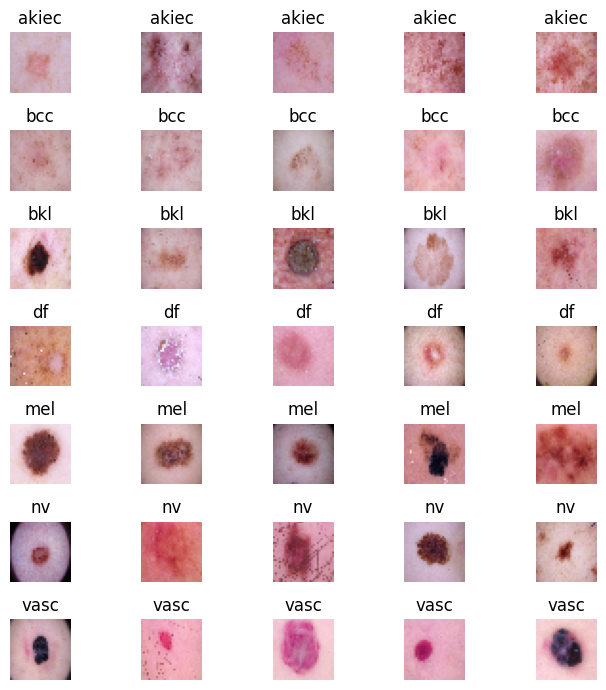

In [ ]:
import matplotlib.pyplot as plt

# Set the number of samples to display for each diagnosis type
n_samples = 5

# Plotting
fig, maxs = plt.subplots(7, n_samples, figsize=(7, 7))

# Iterate over each diagnosis type
for n_axs, (type_name, type_rows) in zip(maxs, skinDf.sort_values(['dx']).groupby('dx')):
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image_array'])
        c_ax.axis('off')
        c_ax.set_title(type_name)

plt.tight_layout()
plt.show()

### Splitting the data

In [ ]:
X = np.asarray(skinDf['image_array'].tolist())
X = X/255. #max pixel
y = skinDf['label']
y_cat = to_categorical(y, num_classes= 7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

### Balancing the dataset using Adaptive Synthetic Sampling (ADASYN)

In [ ]:
pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import ADASYN

# Initialize ADASYN
adasyn = ADASYN(random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Balancing the training dataset
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_reshaped, y_train.argmax(axis=1))

# Reshaping the resampled features back to the original shape
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 32, 32, 3)

# Converting the target variable back to one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=7)

print("Resampled training set - X:", X_train_resampled.shape, " y:", y_train_resampled.shape)

Resampled training set - X: (37565, 32, 32, 3)  y: (37565, 7)


## Model Building

###CNN Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    # Flatten layer
    layers.Flatten(),
    # Dense (fully connected) layers
    layers.Dropout(rate=0.5),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(rate=0.5),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(rate=0.5),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(7, activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_resampled , y_train_resampled ,
                    epochs=25 ,
                    batch_size=8,
                    validation_data=(X_test , y_test))

Epoch 1/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.3479 - loss: 1.6686 - val_accuracy: 0.5182 - val_loss: 1.1776
Epoch 2/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.6649 - loss: 0.9245 - val_accuracy: 0.5522 - val_loss: 0.9698
Epoch 3/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7777 - loss: 0.6366 - val_accuracy: 0.5442 - val_loss: 1.1641
Epoch 4/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8305 - loss: 0.4920 - val_accuracy: 0.5801 - val_loss: 1.0079
Epoch 5/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8519 - loss: 0.4359 - val_accuracy: 0.6465 - val_loss: 0.9008
Epoch 6/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8660 - loss: 0.3961 - val_accuracy: 0.6236 - val_loss: 0.9049
Epoch 7/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8914 - loss: 0.3234 - val_accuracy: 0.6640 - val_loss: 0.9186
Epoch 8/25
4696/4696 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8946 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7079 - loss: 1.1266
Test accuracy: 0.7214178442955017


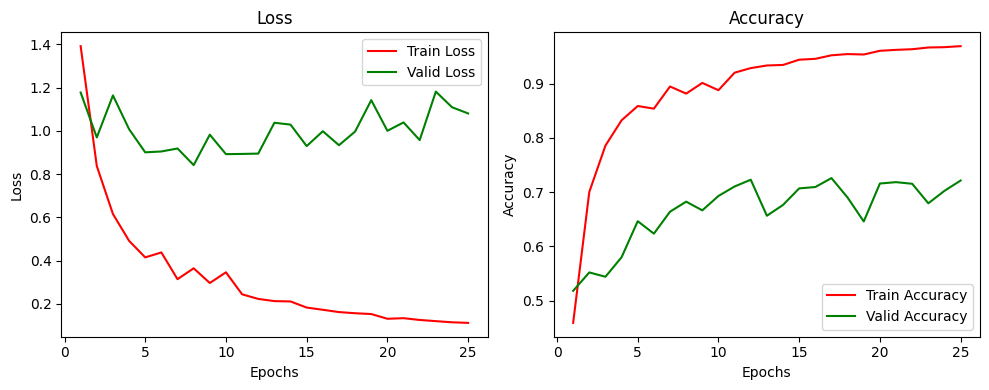

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_labels, y_pred_labels)

print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
              precision    recall  f1-score   support

           0       0.42      0.41      0.41        69
           1       0.54      0.46      0.50        93
           2       0.47      0.41      0.44       228
           3       0.44      0.25      0.32        28
           4       0.41      0.42      0.42       226
           5       0.84      0.87      0.85      1338
           6       0.61      0.81      0.69        21

    accuracy                           0.72      2003
   macro avg       0.53      0.52      0.52      2003
weighted avg       0.71      0.72      0.72      2003



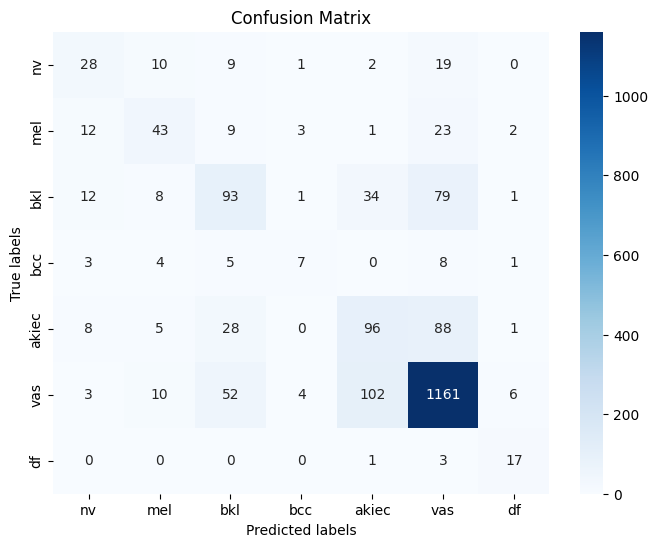

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'], yticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### ResNet Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Loading the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Adding custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base ResNet layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history_resnet = model.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test, y_test))

# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/20
1174/1174 [==============================] - 67s 55ms/step - loss: 1.8419 - accuracy: 0.2380 - val_loss: 1.7484 - val_accuracy: 0.1373
Epoch 2/20
1174/1174 [==============================] - 63s 53ms/step - loss: 1.7542 - accuracy: 0.2738 - val_loss: 1.5971 - val_accuracy: 0.3605
Epoch 3/20
1174/1174 [==============================] - 62s 53ms/step - loss: 1.7182 - accuracy: 0.2961 - val_loss: 1.8520 - val_accuracy: 0.1103
Epoch 4/20
1174/1174 [==============================] - 62s 53ms/step - loss: 1.6814 - accuracy: 0.3215 - val_loss: 1.6572 - val_accuracy: 0.1732
Epoch 5/20
1174/1174 [==============================] - 62s 53ms/step - loss: 1.6571 - accuracy: 0.3388 - val_loss: 1.6713 - val_accuracy: 0.2436
Epoch 6/20
1174/1174 [==============================] - 63s 54ms/step - loss: 1.6295 - accuracy: 0.3513 - val_loss: 2.0645 - val_accuracy: 0.1283
Epoch 7/20
1174/1174 [==============================] - 62s 53ms/step - loss: 1.6279 - accuracy: 0.3529 - val_loss: 1.6751 -

63/63 [==============================] - 4s 49ms/step
              precision    recall  f1-score   support

           0       0.14      0.26      0.19        69
           1       0.15      0.19      0.17        93
           2       0.10      0.01      0.02       228
           3       0.03      0.46      0.06        28
           4       0.22      0.50      0.30       226
           5       0.87      0.08      0.15      1338
           6       0.03      0.90      0.05        21

    accuracy                           0.15      2003
   macro avg       0.22      0.34      0.13      2003
weighted avg       0.63      0.15      0.15      2003



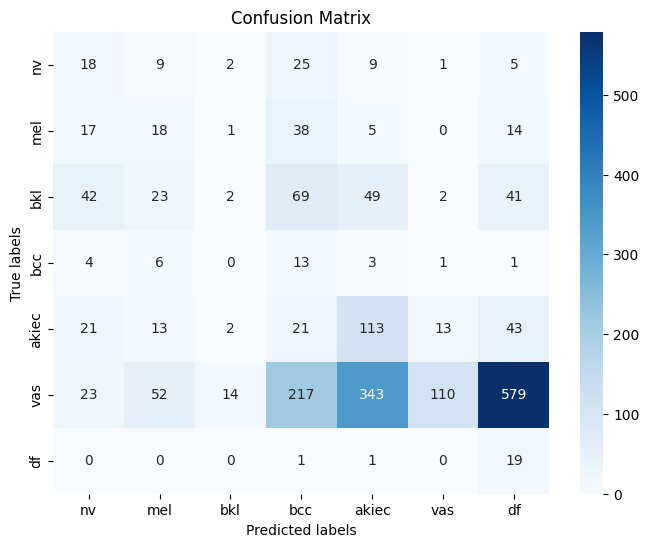

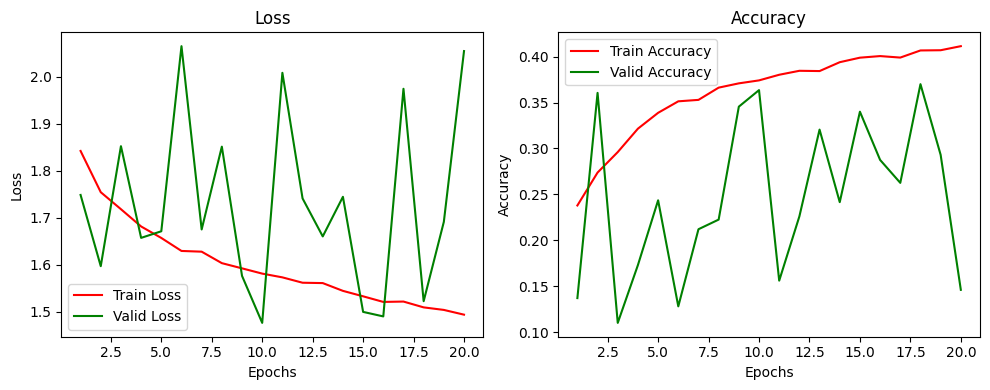

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_labels, y_pred_labels)
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'], yticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation loss and accuracy

tr_acc = history_resnet.history['accuracy']
tr_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


### VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top (classification) layer
base_model = VGG16(weights='imagenet', include_top=False)

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base VGG16 layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg= model.fit(X_train_resampled, y_train_resampled, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
1174/1174 [==============================] - 48s 40ms/step - loss: 1.1466 - accuracy: 0.5635 - val_loss: 1.1608 - val_accuracy: 0.5472
Epoch 2/20
1174/1174 [==============================] - 47s 40ms/step - loss: 0.9268 - accuracy: 0.6477 - val_loss: 1.1975 - val_accuracy: 0.5282
Epoch 3/20
1174/1174 [==============================] - 47s 40ms/step - loss: 0.8101 - accuracy: 0.6939 - val_loss: 1.3075 - val_accuracy: 0.5062
Epoch 4/20
1174/1174 [==============================] - 47s 40ms/step - loss: 0.7346 - accuracy: 0.7255 - val_loss: 1.1231 - val_accuracy: 0.5701
Epoch 5/20
1174/1174 [==============================] - 47s 40ms/step - loss: 0.6718 - accuracy: 0.7516 - val_loss: 1.0338 - val_accuracy: 0.6201
Epoch 6/20
1174/1174 [==============================] - 47s 40ms/step - loss: 0.6202 - accuracy: 0.7720 - val_loss: 1.2380 - val_accuracy: 0.5422
Epoch 7/20
1174/1174 [==============================] - 47s

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_labels, y_pred_labels)

print(report)

63/63 [==============================] - 2s 37ms/step
              precision    recall  f1-score   support

           0       0.29      0.23      0.26        69
           1       0.39      0.49      0.43        93
           2       0.40      0.43      0.41       228
           3       0.29      0.21      0.24        28
           4       0.29      0.43      0.35       226
           5       0.86      0.77      0.81      1338
           6       0.37      0.71      0.48        21

    accuracy                           0.65      2003
   macro avg       0.41      0.47      0.43      2003
weighted avg       0.69      0.65      0.67      2003



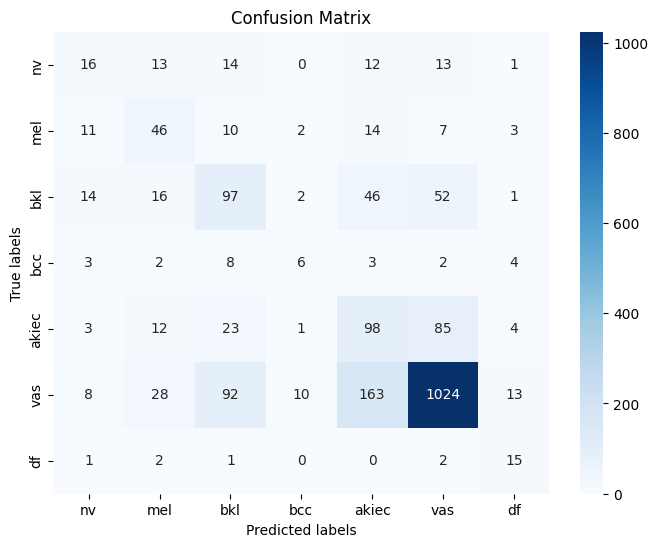

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'], yticklabels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vas', 'df'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

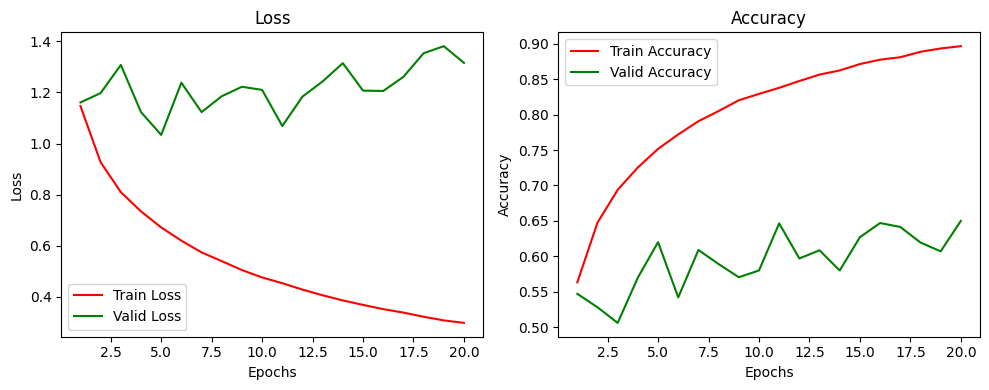

In [ ]:
tr_acc = history_vgg.history['accuracy']
tr_loss = history_vgg.history['loss']
val_acc = history_vgg.history['val_accuracy']
val_loss = history_vgg.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()